In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

# from cutlass import *
# from rbfConv import *
# from tqdm.notebook import tqdm

# from datautils import *
# # from sphUtils import *
# from lossFunctions import *
import math
from scipy import interpolate

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import scipy.special

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# import triangle as tr
from scipy.optimize import minimize

# np
from itertools import product


In [120]:
import numpy as np


def interpolant(t):
    return t*t*t*(t*(t*6 - 15) + 10)


def generate_perlin_noise_2d(
        shape, res, tileable=(False, False), interpolant=interpolant
):
    """Generate a 2D numpy array of perlin noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multple of res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            res.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of shape shape with the generated noise.

    Raises:
        ValueError: If shape is not a multiple of res.
    """
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]]\
             .transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    if tileable[0]:
        gradients[-1,:] = gradients[0,:]
    if tileable[1]:
        gradients[:,-1] = gradients[:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1)
    g00 = gradients[    :-d[0],    :-d[1]]
    g10 = gradients[d[0]:     ,    :-d[1]]
    g01 = gradients[    :-d[0],d[1]:     ]
    g11 = gradients[d[0]:     ,d[1]:     ]
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = interpolant(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)


def generate_fractal_noise_2d(
        shape, res, octaves=1, persistence=0.5,
        lacunarity=2, tileable=(False, False),
        interpolant=interpolant
):
    """Generate a 2D numpy array of fractal noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multiple of lacunarity**(octaves-1)*res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            (lacunarity**(octaves-1)*res).
        octaves: The number of octaves in the noise. Defaults to 1.
        persistence: The scaling factor between two octaves.
        lacunarity: The frequency factor between two octaves.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The, interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of fractal noise and of shape shape generated by
        combining several octaves of perlin noise.

    Raises:
        ValueError: If shape is not a multiple of
            (lacunarity**(octaves-1)*res).
    """
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(
            shape, (frequency*res[0], frequency*res[1]), tileable, interpolant
        )
        frequency *= lacunarity
        amplitude *= persistence
    return noise

In [129]:
# noise = generate_fractal_noise_2d(shape = (256,256), res = (2,2), octaves = 2, persistence = 0.5, lacunarity = 2, tileable = (False, False))

<IPython.core.display.Javascript object>


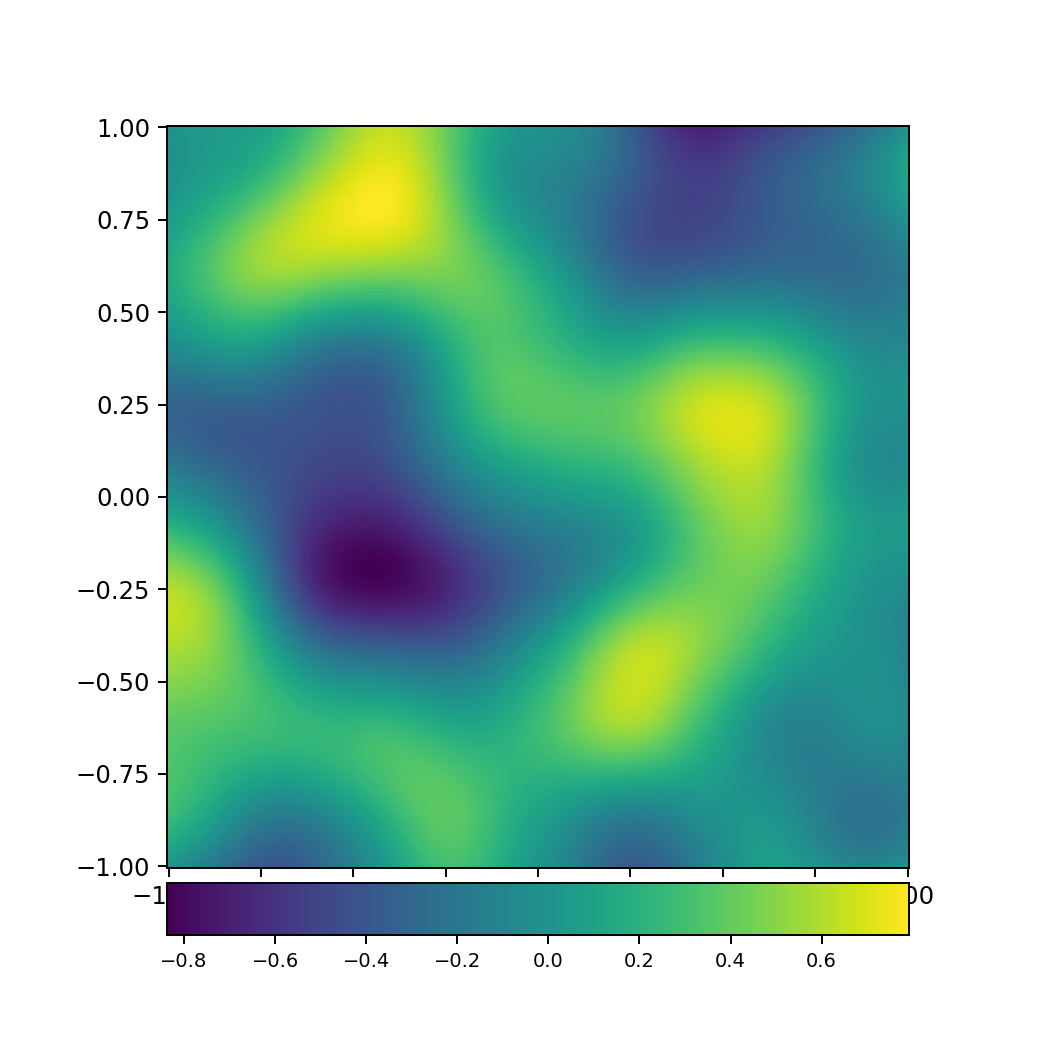

In [132]:
# fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
# # axis[0,0].imshow(noise)
# plotMesh(xx, yy, noise, axis[0,0], fig)

In [111]:
def bezier(segment, t):
    x = segment[:,0]
    y = segment[:,1]
    
    n = segment.shape[0] - 1
    s = np.array([0,0])
    for i in range(n+1):
        s = s + scipy.special.comb(n, i) * np.power(1. -t, n-i) * np.power(t, i) * np.array([x[i], y[i]])
    return s

def bezierCurve(segment, dn = 32):
    dt = 1. / (dn - 1.)
    curve = []
    for i in range(dn):
        curve.append(bezier(segment, dt * i))
    curve = np.array(curve)
    return curve

def makeC1(segments):
    s = np.copy(segments)
    
    for i in range(s.shape[0]):
        s[i,1,:] = 2. * s[i-1,3,:] - s[i-1,2,:]
    return s
def makeC2(segments):
    # Could be better: https://math.stackexchange.com/questions/2625574/c2-continuous-bezier-contour
    Pk = np.array(segments)[:,0,:]
    P = np.vstack((Pk, Pk[0,:]))
    B = np.zeros_like(Pk)
    C = np.zeros_like(Pk)
    A = np.zeros_like(P)

    for k in range(Pk.shape[0]):
        B[k,:] = 1. / 3. * (2. * P[k,:] + P[k+1,:])
        C[k,:] = 1. / 3. * ( P[k,:] + 2. * P[k+1,:])
        
    for k in range(Pk.shape[0]):
        A[k,:] = 1./2. * (C[k-1,:] + B[k,:])
    A[-1,:] = A[0]
    
    segments_c2 = np.copy(segments)
    segments_c2[:,:,:] = 0.
    for i in range(segments_c2.shape[0]):
        segments_c2[i,0,:] = A[i,:]
        segments_c2[i,1,:] = B[i,:]
        segments_c2[i,2,:] = C[i,:]
        segments_c2[i,3,:] = A[i+1,:]
        
    return segments_c2


In [112]:
def genCurves(seed = 0, n = 8, thetaScale = 8., rScale = 0.5, r2Scale = 2.):
    np.random.seed(seed)

    dtheta = 2. * np.pi / (n - 1)
    theta = np.clip(np.random.normal(loc = dtheta / 2., scale = dtheta / thetaScale, size = n-1),0,dtheta) + np.arange(n-1) * dtheta

    r = np.random.normal(loc = 1., scale = rScale, size = n-1)

    segments = []
    for i in range(n-2):
        segments.append(np.array([[theta[i], r[i]],[0,0],[0,0],[theta[i+1],r[i+1]]]))
    segments.append(np.array([[theta[-1],r[-1]],[0,0],[0,0],[theta[0],r[0]]]))

    for s in segments:
        theta = s[:,0]
        r = s[:,1]

        dangle = theta[-1] - theta[0] if theta[-1] > theta[0] else np.fmod(2. * np.pi + (theta[-1] - theta[0]), 2. * np.pi)
        rmin = np.min((r[-1], r[0]))
        dr = np.abs(r[-1] - r[0])

        rRand = np.random.normal(loc = rmin + dr / 2., scale = dr / r2Scale, size=2)

        thetaRand = np.random.uniform(low = theta[0], high = theta[0] + dangle, size = 2)
        thetaRand = np.sort(thetaRand)

        s[1:3,0] = thetaRand
        s[1:3,1] = rRand


    for s in segments:
        theta = s[:,0]
        r = s[:,1]
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        s[:,0] = x
        s[:,1] = y

    segments_c1 = makeC1(segments)
    segments_c2 = makeC2(segments)

    return segments, segments_c1, segments_c2

In [113]:
def getLs(segments):
    ls = []
    for s in segments:
        curve = bezierCurve(s, dn = 100)
        c0 = curve[:curve.shape[0] - 1]
        c1 = curve[1:]
        d = c1 - c0
        l = np.linalg.norm(d,axis=1).sum()
        ls.append(l)
    ls = np.array(ls)
    return ls
def evalBezier(t, ls, segments):
    length = ls.sum()
    lcs = np.cumsum(ls)
    lt = t * length
    index = np.argmax(lcs >= lt)
    offset = 0. if index == 0 else lcs[index - 1]
    lrel = (lt - offset) / ls[index]
    return bezier(segments[index], lrel)
def buildRegularPolygon(segments, nb):
    ls = getLs(segments)    
#     print(ls)
    points = []
    for i in range(nb):
        points.append(evalBezier(i / nb, ls, segments))
    points.append(points[0])
    points = np.array(points)
    
    return points

In [114]:
@torch.jit.script
def sdPoly(poly, p):    
    with record_function("sdPoly"): 
        N = len(poly)

        i = torch.arange(N, device = p.device, dtype = torch.int64)
        i2 = (i + 1) % N
        e = poly[i2] - poly[i]
        v = p - poly[i][:,None]

        ve = torch.einsum('npd, nd -> np', v, e)
        ee = torch.einsum('nd, nd -> n', e, e)

        pq = v - e[:,None] * torch.clamp(ve / ee[:,None], min = 0, max = 1)[:,:,None]

        d = torch.einsum('npd, npd -> np', pq, pq)
        d = torch.min(d, dim = 0).values

        wn = torch.zeros((N, p.shape[0]), device = p.device, dtype = torch.int64)

        cond1 = 0 <= v[i,:,1]
        cond2 = 0 >  v[i2,:,1]
        val3 = e[i,0,None] * v[i,:,1] - e[i,1,None] * v[i,:,0]

        c1c2 = torch.logical_and(cond1, cond2)
        nc1nc2 = torch.logical_and(torch.logical_not(cond1), torch.logical_not(cond2))

        wn[torch.logical_and(c1c2, val3 > 0)] += 1
        wn[torch.logical_and(nc1nc2, val3 < 0)] -= 1

        wn = torch.sum(wn,dim=0)
        s = torch.ones(p.shape[0], device = p.device, dtype = p.dtype)
        s[wn != 0] = -1

        return s * torch.sqrt(d)
@torch.jit.script
def sdPolyDer(poly, p, dh :float = 1e-4, inverted :bool = False):
    with record_function("sdPolyDer"): 
#         dh = 1e-2
        dpx = torch.zeros_like(p)
        dnx = torch.zeros_like(p)
        dpy = torch.zeros_like(p)
        dny = torch.zeros_like(p)

        dpx[:,0] += dh
        dnx[:,0] -= dh
        dpy[:,1] += dh
        dny[:,1] -= dh

        c = sdPoly(poly, p)
        cpx = sdPoly(poly, p + dpx)
        cnx = sdPoly(poly, p + dnx)
        cpy = sdPoly(poly, p + dpy)
        cny = sdPoly(poly, p + dny)

        if inverted:
            c = -c
            cpx = -cpx
            cnx = -cnx
            cpy = -cpy
            cny = -cny

        grad = torch.zeros_like(p)
        grad[:,0] = (cpx - cnx) / (2 * dh)
        grad[:,1] = (cpy - cny) / (2 * dh)

        gradLen = torch.linalg.norm(grad, dim =1)
        grad[torch.abs(gradLen) > 1e-5] /= gradLen[torch.abs(gradLen)>1e-5,None]

        return c, grad, cpx, cnx, cpy, cny

In [115]:
def buildPolygon(scaling = 0.25, seed = 7361, n = 14, dn = 10, thetaScale = 10.5, rScale = 0.65):
    _, _, shape = genCurves(seed = seed, n = n, thetaScale = thetaScale, rScale = rScale)
    curves = []

    for i, s in enumerate(shape):
        curve = bezierCurve(s, dn = dn)
        if i != 0:
            curve = curve[1:]
        curves.append(curve)    
    np.vstack(curves).shape


    poly = np.vstack(curves)

    poly[:,0] = (poly[:,0] - np.min(poly[:,0])) / (np.max(poly[:,0]) - np.min(poly[:,0])) * 2 - 1
    poly[:,1] = (poly[:,1] - np.min(poly[:,1])) / (np.max(poly[:,1]) - np.min(poly[:,1])) * 2 - 1
    poly = poly * scaling
    return poly, shape
def buildSDF(poly, minCoord = [-1,-1], maxCoord = [1,1], n = 256, dh = 1e-2):
    
    x = np.linspace(minCoord[0],maxCoord[0],n)
    y = np.linspace(minCoord[1],maxCoord[1],n)

    xx, yy = np.meshgrid(x,y)

    sdf, sdfGrad, _, _, _, _ = sdPolyDer(torch.tensor(poly[:-1,:]), torch.tensor(np.vstack((xx.flatten(),yy.flatten()))).mT, dh = dh)
    
    return xx, yy, sdf, sdfGrad
def plotMesh(xx,yy,z, axis, fig):
    im = axis.pcolormesh(xx,yy,z)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
    
def plotPoly(poly, axis):
    for i in range(poly.shape[0] - 1):
        axis.plot([poly[i,0], poly[i+1,0]], [poly[i,1], poly[i+1,1]], color = 'red' if i%2 == 0 else 'blue', alpha = 1.)
    

In [116]:
poly, shape = buildPolygon()
xx, yy, sdf, sdfGrad = buildSDF(poly, n = 256)

<IPython.core.display.Javascript object>


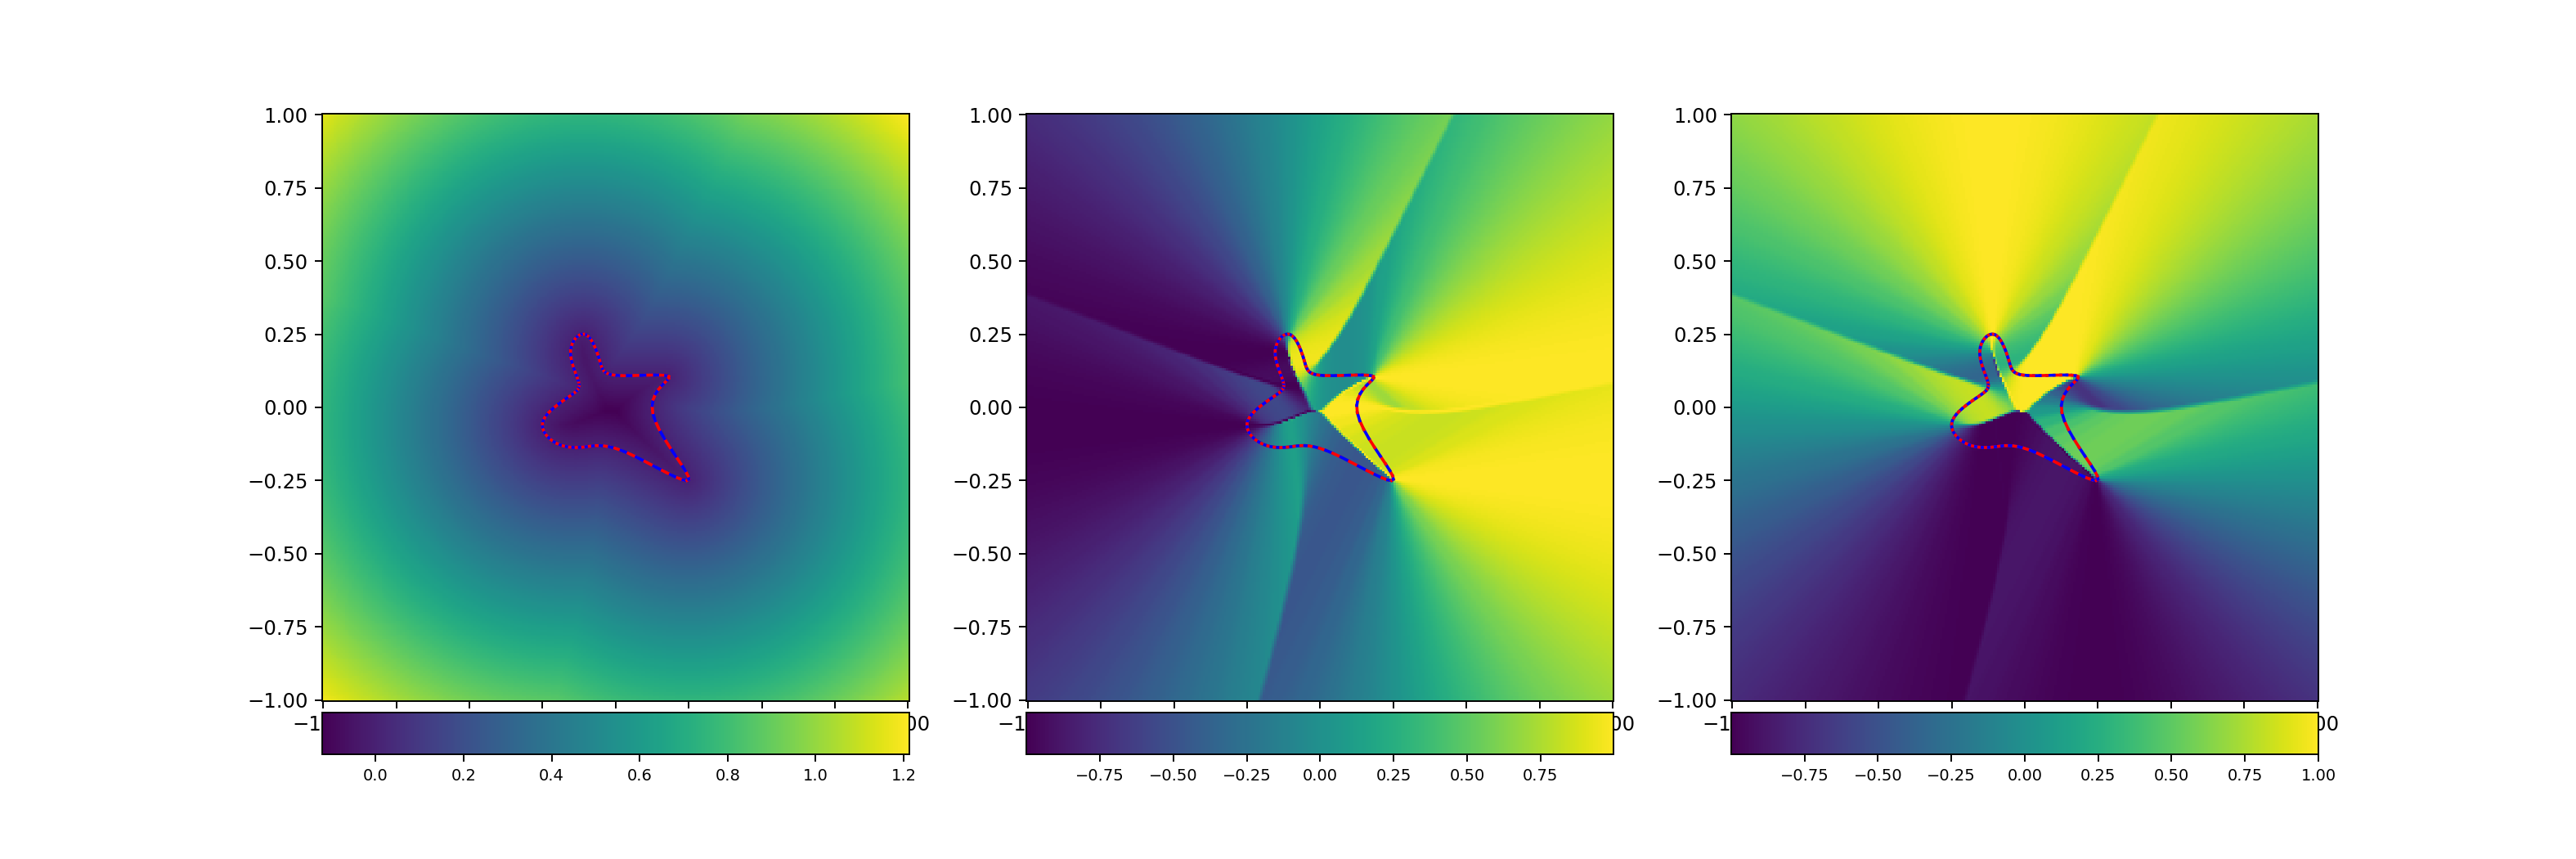

In [117]:
fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)

plotPoly(poly, axis[0,0])
plotPoly(poly, axis[0,1])
plotPoly(poly, axis[0,2])

plotMesh(xx,yy,sdf.numpy().reshape(xx.shape), axis[0,0], fig)
plotMesh(xx,yy,sdfGrad[:,0].numpy().reshape(xx.shape), axis[0,1], fig)
plotMesh(xx,yy,sdfGrad[:,1].numpy().reshape(xx.shape), axis[0,2], fig)


In [139]:
def createNoiseFunction(n = 256, res = 2, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336):
    noise = generate_fractal_noise_2d(shape = (n,n), res = (res,res), octaves = octaves, persistence = persistance, lacunarity = lacunarity, tileable = (False, False))
#     noise = Octave(n, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)

#     noise[:,0] = noise[:,1] - noise[:,2] + noise[:,1]
#     noise[0,:] = noise[1,:] - noise[2,:] + noise[1,:]

#     noise = noise[:n,:n] / 255
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    xx, yy = np.meshgrid(x,y)

    f = interpolate.RegularGridInterpolator((x, y), noise, bounds_error = False, fill_value = None, method = 'linear')
    
    return f, noise

def createVelocityField(f, n = 256):
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)

    xx, yy = np.meshgrid(x,y)

    z = f((xx, yy))
    zxp = f((xx + 1e-4, yy))
    zxn = f((xx - 1e-4, yy))
    zyp = f((xx, yy + 1e-4))
    zyn = f((xx, yy - 1e-4))
    xv = (zxp - zxn) / (2 * 1e-4)
    yv = (zyp - zyn) / (2 * 1e-4)
#     print(xv)
#     print(yv)
    
    return np.stack((xv, yv), axis = 2), xx, yy, z

<IPython.core.display.Javascript object>


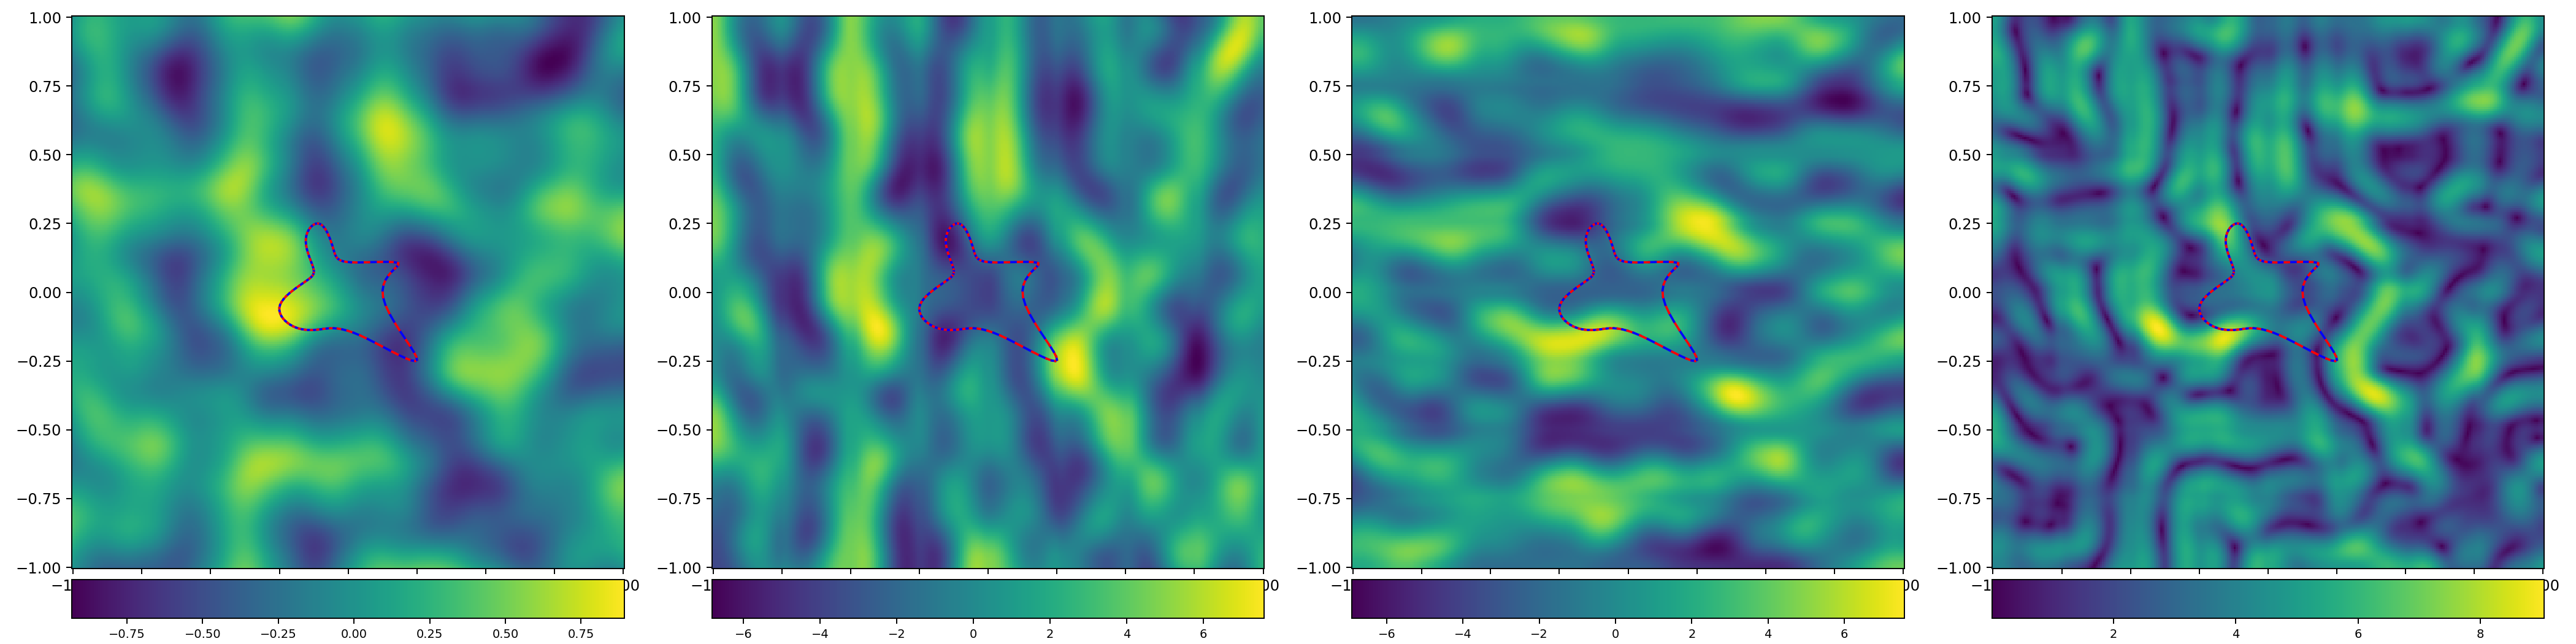

In [142]:
f, noise = createNoiseFunction(n = 256, res = 4, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336)
velocityField, xx, yy, potential = createVelocityField(f, n = 256)    

fig, axis = plt.subplots(1, 4, figsize=(24,6), sharex = False, sharey = False, squeeze = False)

plotPoly(poly, axis[0,0])
plotPoly(poly, axis[0,1])
plotPoly(poly, axis[0,2])
plotPoly(poly, axis[0,3])

plotMesh(xx, yy, potential, axis[0,0], fig)
plotMesh(xx, yy, velocityField[:,:,0], axis[0,1], fig)
plotMesh(xx, yy, velocityField[:,:,1], axis[0,2], fig)
plotMesh(xx, yy, np.linalg.norm(velocityField, axis = 2), axis[0,3], fig)

fig.tight_layout()

In [143]:
def createPotentialField(n = 256, res = 4, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336):
    f, noise = createNoiseFunction(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = 1336)
#     noise = Octave(n, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)

#     noise[:,0] = noise[:,1] - noise[:,2] + noise[:,1]
#     noise[0,:] = noise[1,:] - noise[2,:] + noise[1,:]

#     noise = noise[:n,:n] / 255
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    xx, yy = np.meshgrid(x,y)

#     f = interpolate.RegularGridInterpolator((x, y), noise, bounds_error = False, fill_value = None, method = 'linear')
    
    return xx,yy,noise

In [144]:
# print(poly)

In [274]:
dh = 1e-5

boundary = 0.25
_, _, domainSDF, domainSDFGrad = buildSDF(np.array([[-1.0 + boundary,-1 + boundary],[1 - boundary,-1 + boundary],\
                                                    [1 - boundary,1 - boundary],[-1 + boundary,1 - boundary],[-1 + boundary,-1 + boundary]]), n = 256, dh = dh)

# poly, shape = buildPolygon()
# xx, yy, polySDF, polySDFGrad = buildSDF(poly, n = 256)
_, _, polySDF, polySDFGrad = buildSDF(np.array([[-0.25,-0.25],[0.25,-0.25],[0.25,0.25],[-0.25,0.25],[-0.25,-0.25]]), n = 256, dh = dh)
# s = smoothstep(-1, 1, np.abs(-domainSDF.numpy()) - 0.125)
# s = smoothstep(-1, 1, np.abs(polySDF.numpy()) - 0.125)
s = (- domainSDF + boundary).numpy()
# s = np.clip(s.reshape(xx.shape), a_min = 0, a_max = None)
s = s.reshape(xx.shape)


In [275]:
def smoothstep(edge0, edge1, x):
    r = ( x - edge0) / (edge1 - edge0)
    ramped = r * r * ( 3 - 2 * x)
    ramped[ramped < edge0] = 0
    ramped[ramped >= edge1] = 1
    return ramped

In [276]:
# float smoothstep (float edge0, float edge1, float x)
# {
#    if (x < edge0)
#       return 0;

#    if (x >= edge1)
#       return 1;

#    // Scale/bias into [0..1] range
#    x = (x - edge0) / (edge1 - edge0);

#    return x * x * (3 - 2 * x);
# }

<IPython.core.display.Javascript object>


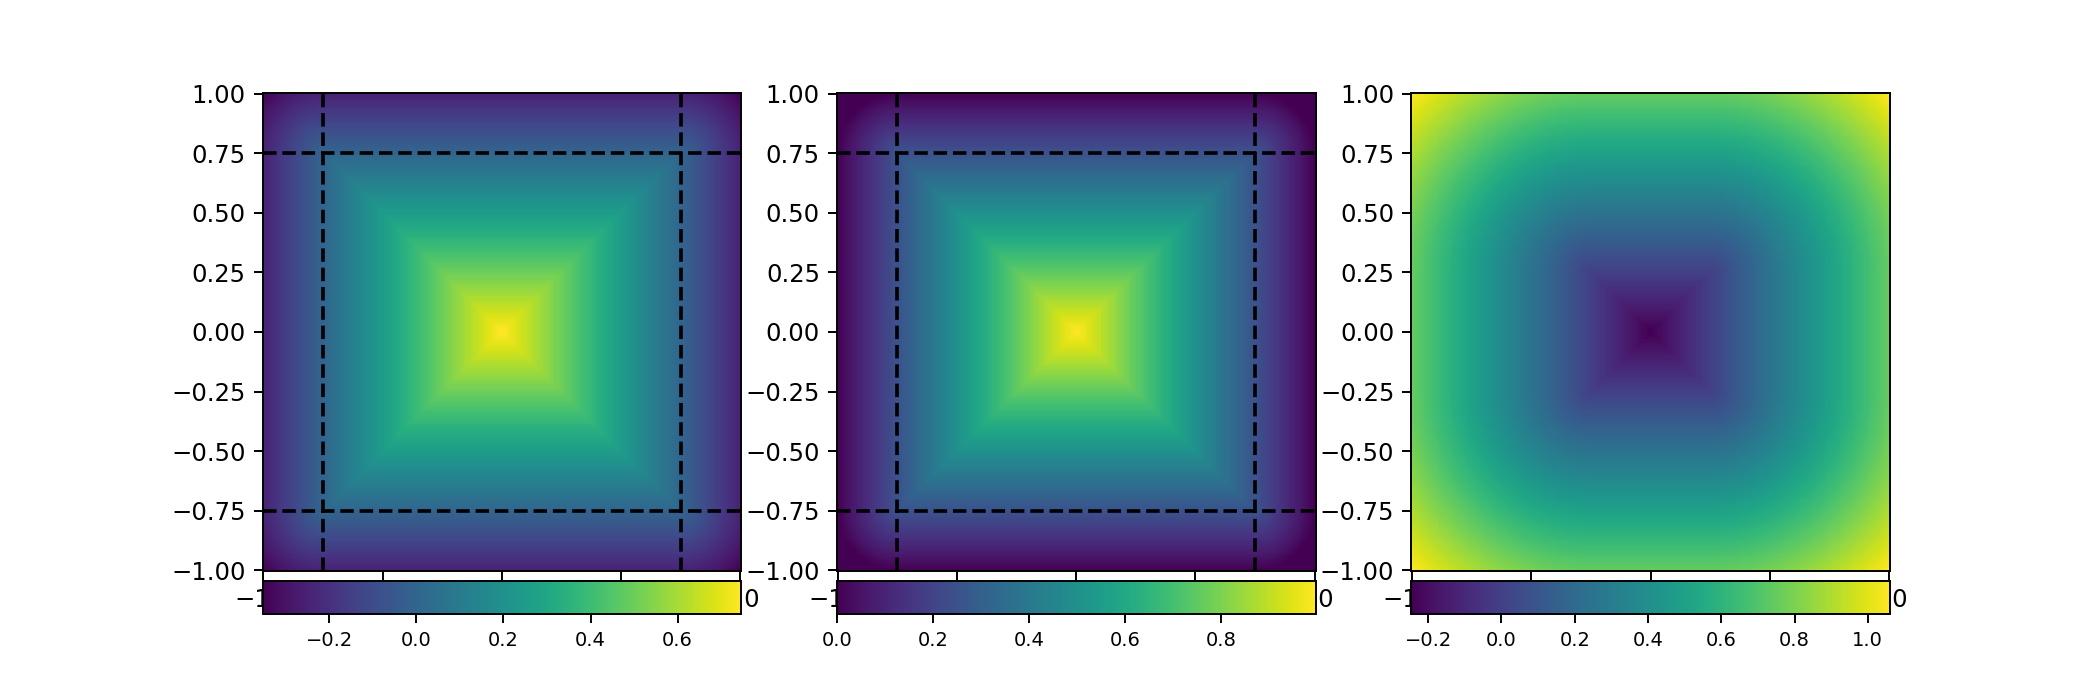

In [284]:
# s = smoothstep(-1, 1, np.abs(-domainSDF.numpy()) - 0.125)
# s = smoothstep(-1, 1, np.abs(polySDF.numpy()) - 0.125)
s = (- domainSDF + boundary).numpy()
# s = np.clip(s.reshape(xx.shape), a_min = 0, a_max = None)
s = s.reshape(xx.shape)

xxf = xx.flatten()
yyf = yy.flatten()
maskLR = np.logical_and(xxf < -1 + boundary, yyf < -1 + boundary)
# s[maskLR] = s[maskLR] - boundary - np.sqrt((xxf + 1 - boundary)**2 + (yyf + 1 - boundary)**2)[maskLR]
# s[np.logical_not(np.logical_and(xxf < -1 + boundary, yyf < -1 + boundary))] = 1
fig, axis = plt.subplots(1, 3, figsize=(12, 4), sharex = False, sharey = False, squeeze = False)

plotMesh(xx, yy, -domainSDF.numpy().reshape(xx.shape), axis[0,0], fig)
plotMesh(xx, yy, np.clip(s.reshape(xx.shape), a_min = 0, a_max = None), axis[0,1], fig)
plotMesh(xx, yy, polySDF.numpy().reshape(xx.shape), axis[0,2], fig)

axis[0,0].axvline(-1 + boundary, ls = '--',  c= 'black')
axis[0,0].axvline( 1 - boundary, ls = '--',  c= 'black')
axis[0,0].axhline(-1 + boundary, ls = '--',  c= 'black')
axis[0,0].axhline( 1 - boundary, ls = '--',  c= 'black')

axis[0,1].axvline(-1 + boundary, ls = '--',  c= 'black')
axis[0,1].axvline( 1 - boundary, ls = '--',  c= 'black')
axis[0,1].axhline(-1 + boundary, ls = '--',  c= 'black')
axis[0,1].axhline( 1 - boundary, ls = '--',  c= 'black')

<IPython.core.display.Javascript object>


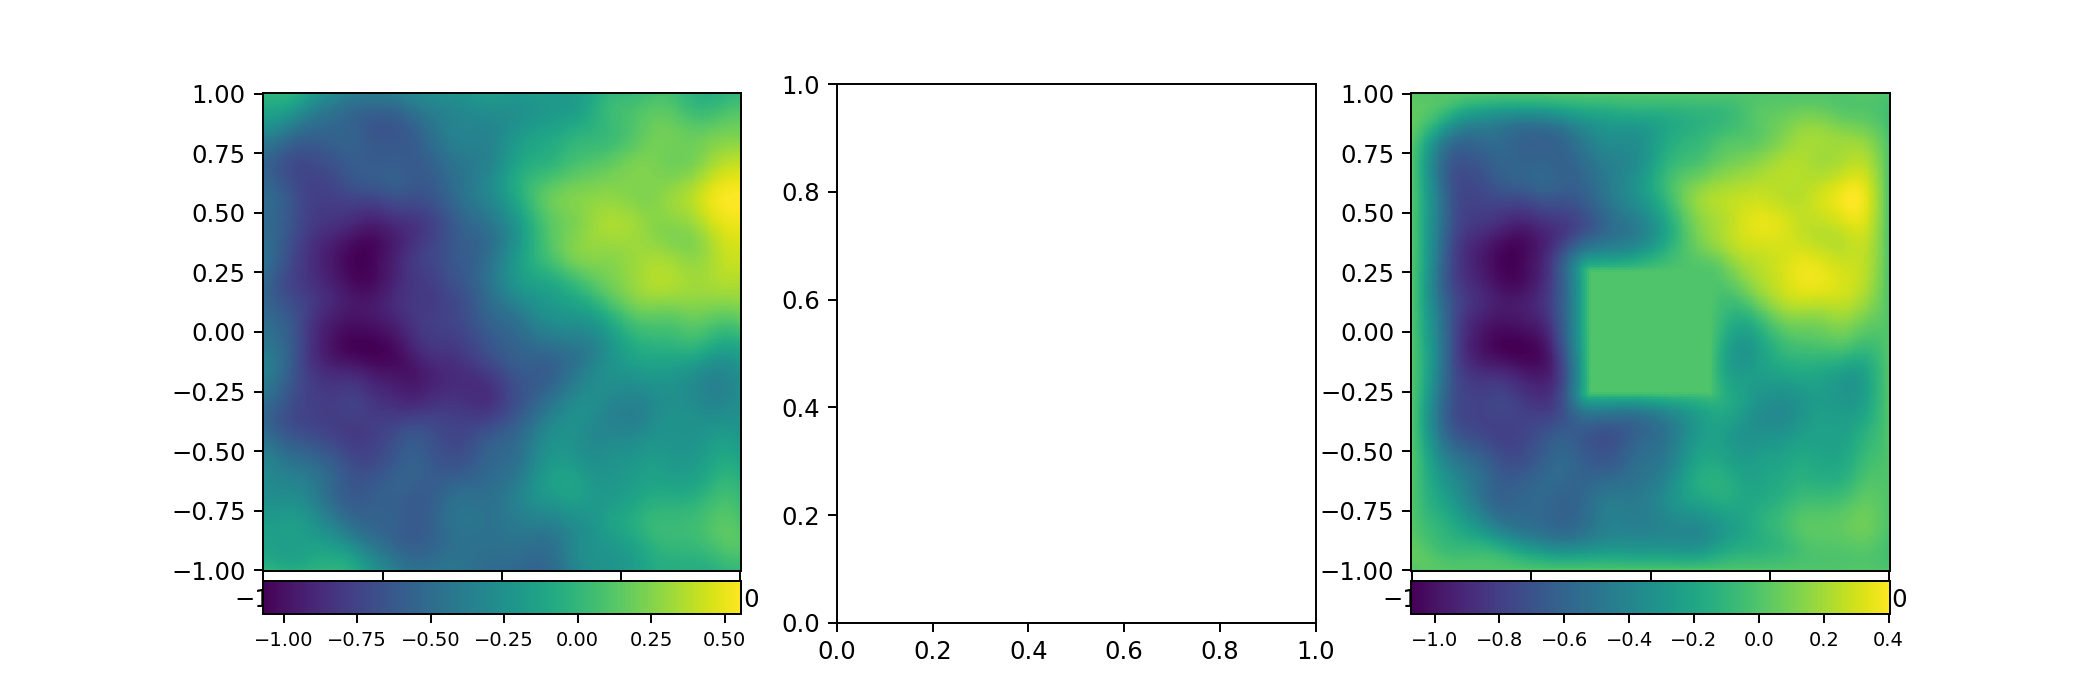

/tmp/ipykernel_1453/1261004174.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)


In [290]:
xx, yy, noise = createPotentialField(n = 256, res = 1, octaves = 4, lacunarity = 2, persistance = 0.5, seed = 1336)

# noise[:,:] = 1

fig, axis = plt.subplots(1, 3, figsize=(12, 4), sharex = False, sharey = False, squeeze = False)

plotMesh(xx, yy, noise, axis[0,0], fig)

# d0 = 0.25

def filterPotential(noise, sdf, d0 = 0.25):
    r = sdf / d0
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
#     ramped[r <= 0] = 0
    ramped[r <= -1] = -1
    
    return ramped * noise
    # ramped = r


filtered = filterPotential(torch.tensor(noise).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
filtered[polySDF.reshape(noise.shape) < 0] = 0
    
# plotMesh(xx, yy, ramped.numpy().reshape(xx.shape), axis[0,1], fig)
plotMesh(xx, yy, filtered, axis[0,2], fig)

x = np.linspace(-1,1,256)
y = np.linspace(-1,1,256)
f = interpolate.RegularGridInterpolator((x, y), filtered, bounds_error = False, fill_value = None, method = 'linear')



In [ ]:
def filterPotential(noise, sdf, d0 = 0.25):
    r = sdf / d0
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
#     ramped[r <= 0] = 0
    ramped[r <= -1] = -1
    
    return ramped * noise
    # ramped = r



In [301]:
dh = 1e-3

boundary = 0.25
_, _, domainSDF, domainSDFGrad = buildSDF(np.array([[-1.0 + boundary,-1 + boundary],[1 - boundary,-1 + boundary],\
                                                    [1 - boundary,1 - boundary],[-1 + boundary,1 - boundary],[-1 + boundary,-1 + boundary]]), n = 256, dh = dh)

# poly, shape = buildPolygon()
# xx, yy, polySDF, polySDFGrad = buildSDF(poly, n = 256)
_, _, polySDF, polySDFGrad = buildSDF(np.array([[-0.25,-0.25],[0.25,-0.25],[0.25,0.25],[-0.25,0.25],[-0.25,-0.25]]), n = 256, dh = dh)
s = (- domainSDF + boundary).numpy()
s = s.reshape(xx.shape)


/tmp/ipykernel_1453/4282089951.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)


<IPython.core.display.Javascript object>


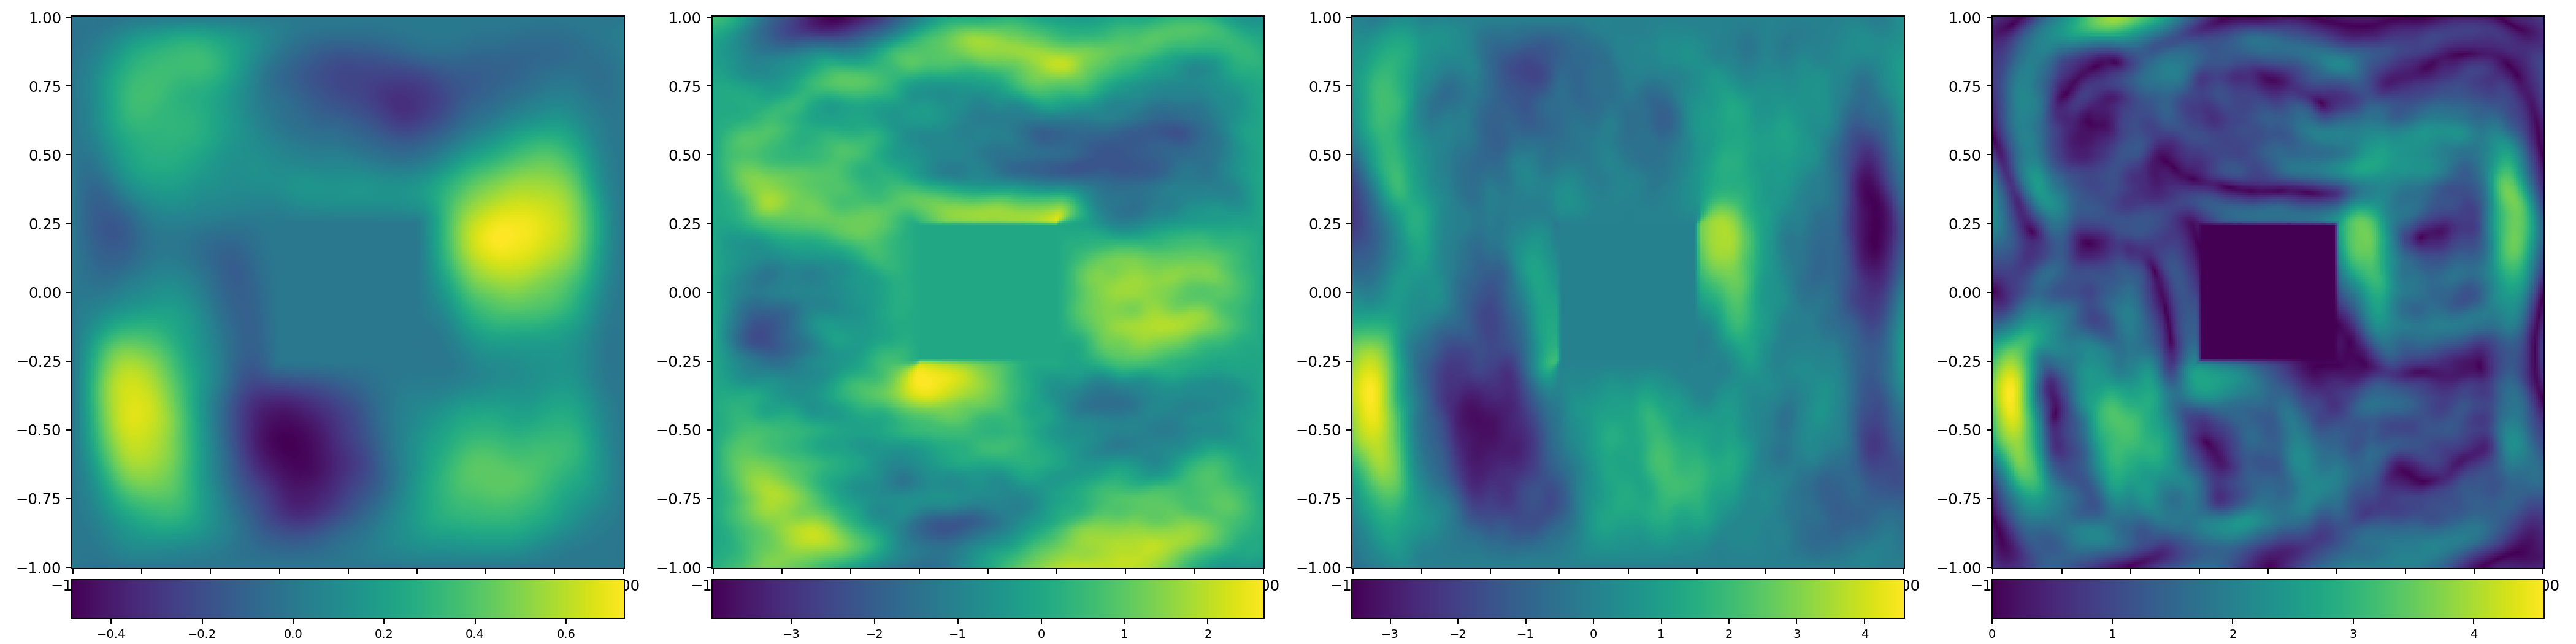

In [303]:


xx, yy, noise = createPotentialField(n = 256, res = 2, octaves = 4, lacunarity = 2, persistance = 0.25, seed = 1336)
filtered = filterPotential(torch.tensor(noise).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
filtered[polySDF.reshape(noise.shape) < 0] = 0

x = np.linspace(-1,1,256)
y = np.linspace(-1,1,256)
f = interpolate.RegularGridInterpolator((x, y), filtered, bounds_error = False, fill_value = None, method = 'linear')

velocityField, xx, yy, potential = createVelocityField(f, n = 256)    

fig, axis = plt.subplots(1, 4, figsize=(24,6), sharex = False, sharey = False, squeeze = False)

# plotPoly(poly, axis[0,0])
# plotPoly(poly, axis[0,1])
# plotPoly(poly, axis[0,2])
# plotPoly(poly, axis[0,3])

plotMesh(xx, yy, potential.transpose(), axis[0,0], fig)
plotMesh(xx, yy, velocityField[:,:,0].transpose(), axis[0,1], fig)
plotMesh(xx, yy, velocityField[:,:,1].transpose(), axis[0,2], fig)
plotMesh(xx, yy, np.linalg.norm(velocityField, axis = 2).transpose(), axis[0,3], fig)

fig.tight_layout()

<IPython.core.display.Javascript object>


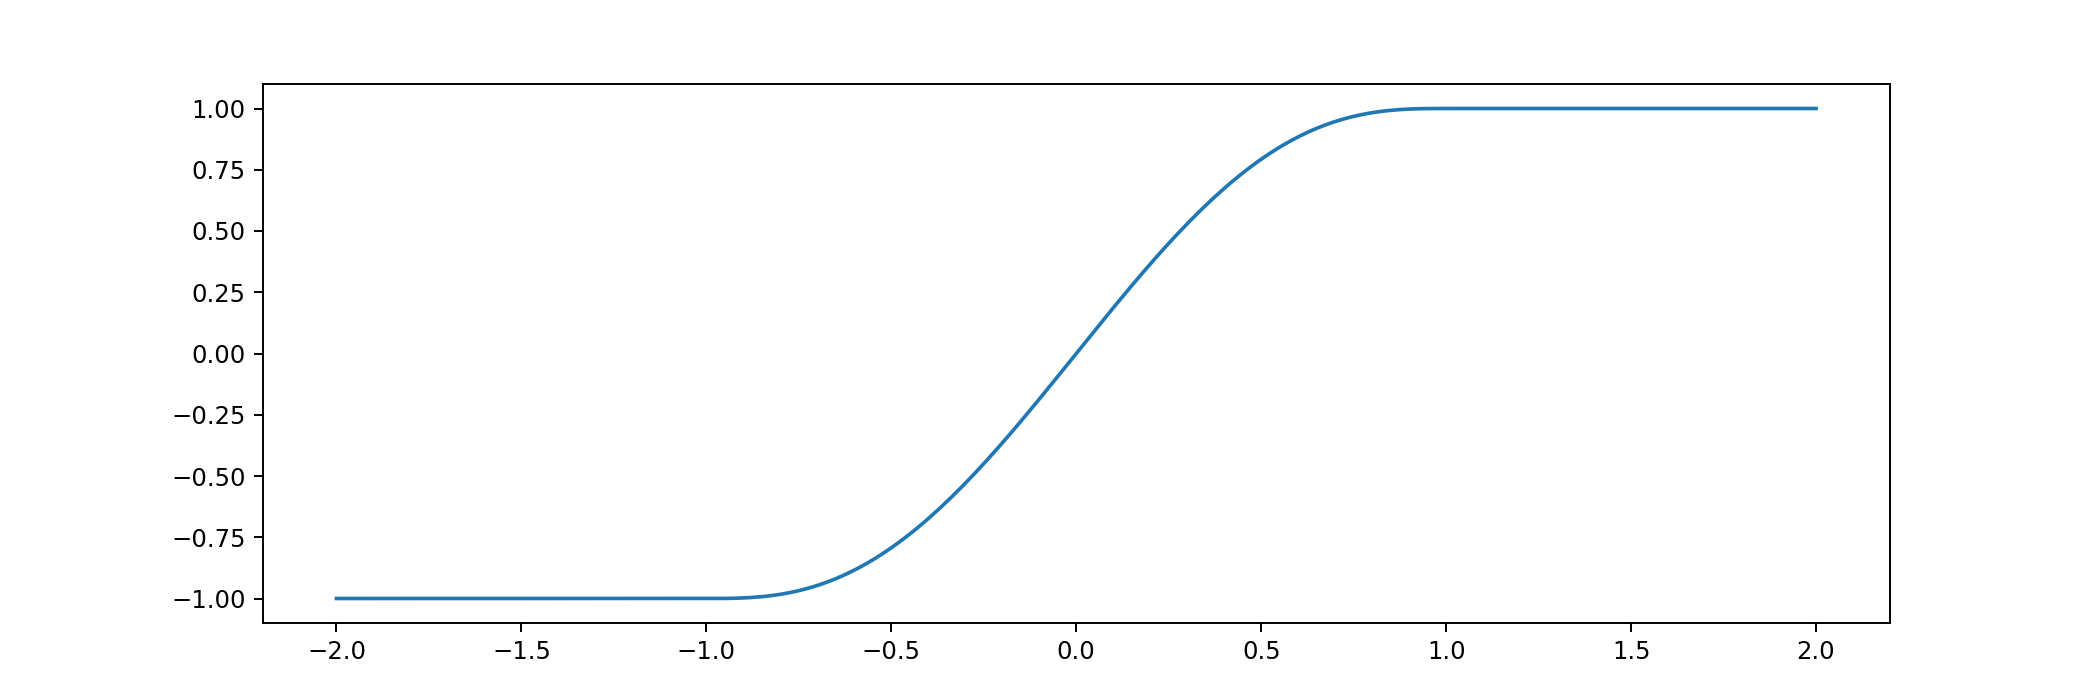

In [57]:

fig, axis = plt.subplots(1, 1, figsize=(12, 4), sharex = False, sharey = False, squeeze = False)
xvals = np.linspace(-2,2,256)
ramped = 15/8 * xvals - 10/8 * xvals**3 + 3/8 * xvals**5
ramped[xvals > 1] = 1
ramped[xvals < -1] = -1

axis[0,0].plot(xvals, ramped)